In [ ]:
import pandas as pd
import numpy as np
from IPython.display import clear_output

In [2]:
from geoxts.benchmark_data import *
from tsai.all import TSDatasets, TSDataLoaders, TSStandardize, Categorize, combine_split_data
from tsai.all import FCN, LSTM, InceptionTime, XceptionTime, XCM, LSTM_FCN, LSTM_FCNPlus
from geoxts.benchmark_models import *

In [3]:
random_seed(0, use_cuda=True)

In [4]:
#We first create downsample the gamma rays to per feet.
df_log = pd.read_parquet('data/well_logs_data/Colorado_data/Training/logs.parquet', engine='fastparquet')
#df_log = df_log.set_index('wellName')
df_log.loc[df_log['GR'] < -1, 'GR' ] = -1
df_loc = pd.read_parquet('data/well_logs_data/Colorado_data/Training/loc.parquet', engine='fastparquet')
df_loc = df_loc.reset_index()
df_log = df_loc.merge(df_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
print(df_log.head())

      wellName   Latitude  Longitude  DEPTH        GR
0  512320698.0  48.673353   2.145178  421.0   96.9752
1  512320698.0  48.673353   2.145178  421.5  102.3324
2  512320698.0  48.673353   2.145178  422.0  104.6432
3  512320698.0  48.673353   2.145178  422.5   99.2187
4  512320698.0  48.673353   2.145178  423.0   92.0200


In [5]:
df_tops = pd.read_parquet('data/well_logs_data/Colorado_data/Training/tops.parquet', engine='fastparquet')
df_tops.set_index('well_name', inplace = True)
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops.head()

,NIOBARA,CODELL,FORT_HAYS
well_name,,,
512320698.0,6398.0,6638.0,6661.0
512320699.0,6407.0,6656.0,6676.0
512320928.0,6520.0,6746.0,6793.0
512320970.0,6544.0,6770.0,6816.0
512320971.0,6510.0,6742.0,6789.0


In [6]:
# Load the training_well array from the file which contains the wells with good signature cluster
well_array = np.load('data/well_logs_data/Colorado_data/Training/training_well_list.npy', allow_pickle=True)

In [7]:
input_variable = ['GR', 'Depth','Latitude','Longitude']
#extract training data
X_train, y_train = extract_dataset_Xy(df_log,df_tops,well_array, input_variable, wsize=201, top_list_bool=1 )
X_train.shape, y_train.shape

((4217, 4, 201), (4217,))

In [8]:
#validing datastet for the recall calculation
df_valid_log = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_50.parquet', engine='fastparquet')
df_valid_log.loc[df_valid_log['GR'] < -1, 'GR' ] = -1
df_valid_log.loc[df_valid_log['GR'] > 400, 'GR' ] = 400
#df_loc = df_loc.reset_index()
df_valid_loc = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/loc_50.parquet', engine='fastparquet')
df_valid_loc = df_valid_loc.reset_index()
df_valid_log = df_valid_loc.merge(df_valid_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
df_valid_tops = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_50.csv')
df_valid_tops = df_valid_tops.set_index('wellName')
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_valid_tops = df_valid_tops[cols]

In [9]:
#create validation dataset 
X_valid, y_valid = extract_dataset_Xy(df_valid_log,df_valid_tops,[],input_variable, wsize=201, top_list_bool=0)
X_valid.shape, y_valid.shape

((796, 4, 201), (796,))

In [10]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
#tensor dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=25, batch_tfms=[TSStandardize(by_var=True)], num_workers=0) 
#dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=25, num_workers=0) 

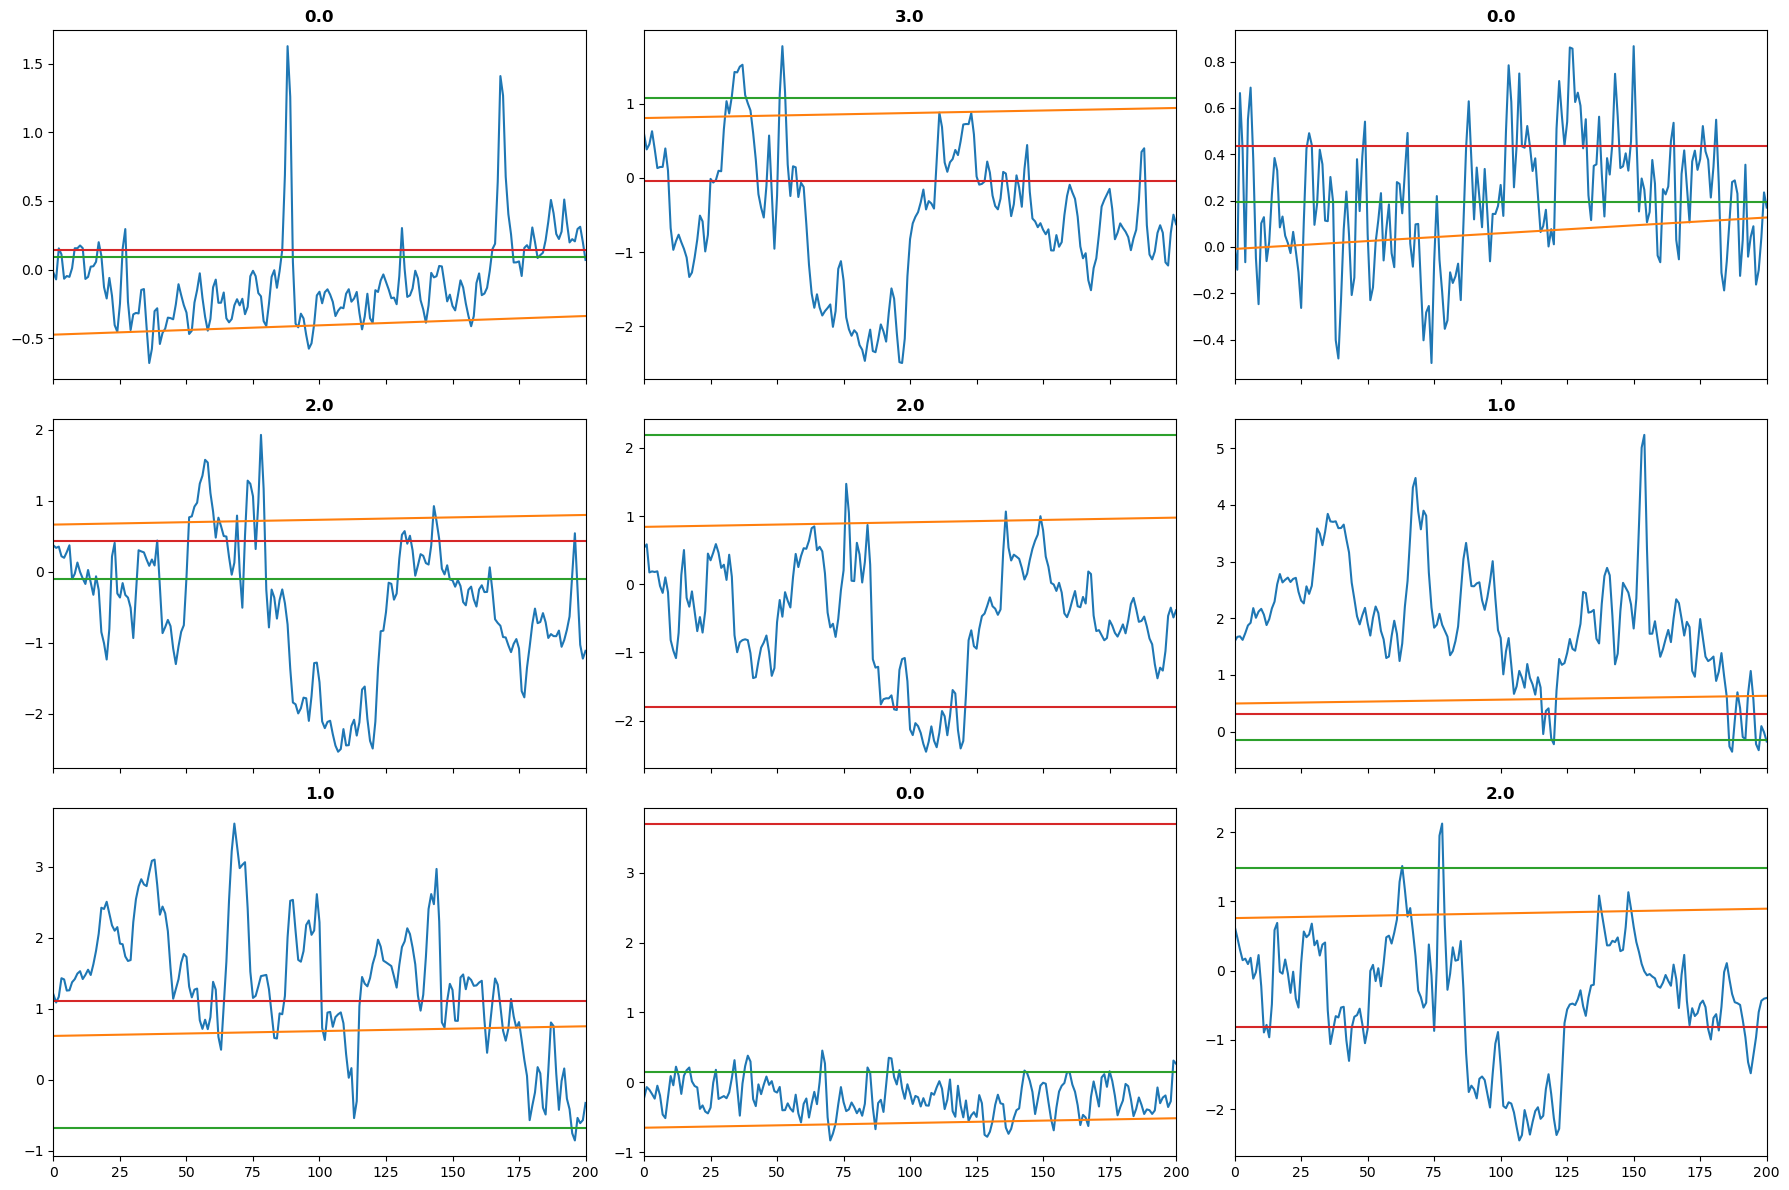

In [11]:
valid_dl = dls.valid
dls.show_batch()

In [12]:
xb, yb = dls.one_batch()
yb

TensorCategory([1, 0, 3, 0, 0, 0, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 2, 0, 1, 0, 0,
                0, 0, 3, 0])

In [13]:
#Testing datastet for the recall calculation
df_test_log = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_100.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400
#df_loc = df_loc.reset_index()
df_test_loc = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/loc_100.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()
df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
df_test_tops = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_100.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_test_tops = df_test_tops[cols]

In [14]:
archs = [(LSTM_FCN, {}), (LSTM_FCNPlus, {}), (XCM, {}), (FCN, {}), (InceptionTime, {}), (XceptionTime, {}), 
         (LSTM, {'n_layers':3, 'bidirectional': False}),(LSTM, {'n_layers':3, 'bidirectional': True})]

In [15]:
from fastai.learner import *
from fastai.metrics import accuracy
import time

In [24]:

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_test_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM,"{'n_layers': 3, 'bidirectional': False}",204404,0.023569,0.149858,0.963568,538
1,LSTM,"{'n_layers': 3, 'bidirectional': True}",568804,0.023082,0.135207,0.962312,1175
2,XceptionTime,{},399960,0.078023,0.117399,0.961055,1503
3,InceptionTime,{},455940,0.006502,0.183810,0.954774,1766
4,LSTM_FCN,{},388868,0.006149,0.223195,0.951005,113
5,LSTM_FCNPlus,{},388868,0.008934,0.204600,0.951005,119
6,XCM,{},259206,0.009104,0.122182,0.945980,573
7,FCN,{},267268,0.122164,0.199791,0.929648,124


,arch,hyperparams,mae,recall,Run time
0,LSTM_FCNPlus,{},8.400000,0.960000,267
1,XceptionTime,{},3.533333,0.956667,1081
2,LSTM_FCN,{},2.856667,0.953333,240
3,XCM,{},4.375000,0.953333,336
4,InceptionTime,{},5.036667,0.903333,2009
5,LSTM,"{'n_layers': 3, 'bidirectional': False}",7.660000,0.823333,1384
6,LSTM,"{'n_layers': 3, 'bidirectional': True}",37.926667,0.683333,2950
7,FCN,{},53.573333,0.306667,461


In [16]:
archs_made = [(LSTM_2dCNN, {}), (LSTM_XCM, {}), (XCM_LSTM, {}), (LSTM_FCN_2dCNN, {})]

In [26]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs_made):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(15, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_test_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM_2dCNN,{},148654,0.007258,0.108835,0.964824,52
1,LSTM_XCM,{},255290,0.004028,0.186673,0.962312,81
2,XCM_LSTM,{},585342,0.011032,0.161934,0.959799,126
3,LSTM_FCN_2dCNN,{},415918,0.003910,0.171381,0.945980,126


,arch,hyperparams,mae,recall,Run time
0,LSTM_2dCNN,{},2.803333,0.976667,157
1,LSTM_FCN_2dCNN,{},3.128333,0.973333,358
2,LSTM_XCM,{},3.738333,0.960000,267
3,XCM_LSTM,{},5.150000,0.956667,375


In [17]:
#optinal download if using any of the functions
from fastai.callback.training import *
from fastai.callback.tracker import *
from fastai.test_utils import *
from fastai.callback.schedule import *

In [18]:

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    try: 
        lr_valley = learn.lr_find(show_plot = False)
    except Exception:
        lr_valley =1e-3
    learn.fit_one_cycle(20, lr_valley, cbs=[SaveModelCallback(monitor='accuracy'), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_test_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM_FCNPlus,{},388868,0.017855,0.161026,0.954774,40
1,InceptionTime,{},455940,0.023668,0.138615,0.954774,229
2,LSTM_FCN,{},388868,0.013429,0.172400,0.952261,47
3,XceptionTime,{},399960,0.032704,0.150262,0.951005,365
4,LSTM,"{'n_layers': 3, 'bidirectional': True}",568804,0.011401,0.278412,0.948492,915
5,XCM,{},259206,0.010455,0.206684,0.947236,91
6,LSTM,"{'n_layers': 3, 'bidirectional': False}",204404,0.198074,0.234425,0.935930,279
7,FCN,{},267268,0.101233,0.267854,0.907035,108


,arch,hyperparams,mae,recall,Run time
0,LSTM_FCNPlus,{},7.430000,0.980000,200
1,LSTM_FCN,{},10.386667,0.970000,226
2,XCM,{},4.366667,0.960000,361
3,XceptionTime,{},3.070000,0.960000,983
4,InceptionTime,{},17.683333,0.813333,1031
5,LSTM,"{'n_layers': 3, 'bidirectional': True}",53.290000,0.530000,2774
6,FCN,{},55.791667,0.333333,216
7,LSTM,"{'n_layers': 3, 'bidirectional': False}",52.680000,0.223333,1326


In [19]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs_made):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(15, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_test_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,XCM_LSTM,{},585342,0.002610,0.227482,0.966080,128
1,LSTM_2dCNN,{},148654,0.004100,0.247794,0.962312,56
2,LSTM_FCN_2dCNN,{},415918,0.000851,0.228689,0.956030,126
3,LSTM_XCM,{},255290,0.000075,0.480422,0.945980,79


,arch,hyperparams,mae,recall,Run time
0,LSTM_FCN_2dCNN,{},8.441667,0.963333,353
1,XCM_LSTM,{},8.801667,0.953333,380
2,LSTM_2dCNN,{},3.646667,0.933333,164
3,LSTM_XCM,{},14.878333,0.900000,255
